In [45]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [55]:
data = pd.read_csv('/Users/rampageyao/Desktop/tum/applied machine intelligence/project/elec_forecast.csv')

Price = data['Spot price']
Date = data['Date']

data = data.drop(['Spot price','Date'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of day                56220 non-null  int64  
 1   Biomass[MWh]               56124 non-null  float64
 2   Hydropower[MWh]            56124 non-null  float64
 3   Wind offshore[MWh]         56144 non-null  float64
 4   Wind onshore[MWh]          56143 non-null  float64
 5   Photovoltaics[MWh]         56120 non-null  float64
 6   Other renewable[MWh]       56124 non-null  float64
 7   Nuclear[MWh]               56124 non-null  float64
 8   Fossil brown coal[MWh]     56148 non-null  float64
 9   Fossil hard coal[MWh]      56124 non-null  float64
 10  Fossil gas[MWh]            56124 non-null  float64
 11  Hydro pumped storage[MWh]  56124 non-null  float64
 12  Other conventional[MWh]    56124 non-null  float64
 13  Total[MWh]                 56220 non-null  flo

In [56]:
data = data.fillna(method="bfill")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of day                56220 non-null  int64  
 1   Biomass[MWh]               56220 non-null  float64
 2   Hydropower[MWh]            56220 non-null  float64
 3   Wind offshore[MWh]         56220 non-null  float64
 4   Wind onshore[MWh]          56220 non-null  float64
 5   Photovoltaics[MWh]         56220 non-null  float64
 6   Other renewable[MWh]       56220 non-null  float64
 7   Nuclear[MWh]               56220 non-null  float64
 8   Fossil brown coal[MWh]     56220 non-null  float64
 9   Fossil hard coal[MWh]      56220 non-null  float64
 10  Fossil gas[MWh]            56220 non-null  float64
 11  Hydro pumped storage[MWh]  56220 non-null  float64
 12  Other conventional[MWh]    56220 non-null  float64
 13  Total[MWh]                 56220 non-null  flo

Text(0, 0.5, 'Cumulative Explained Variance')

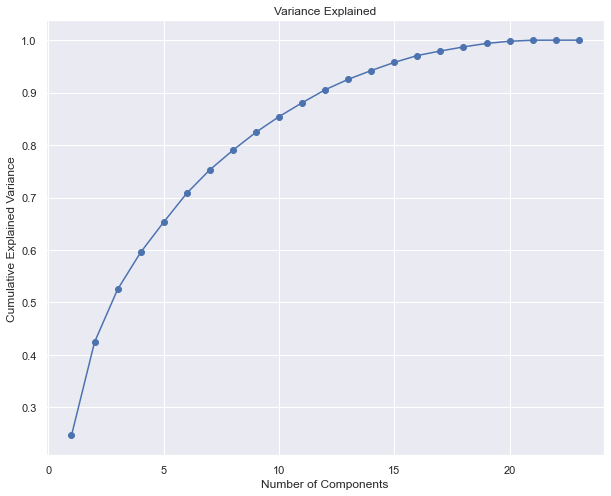

In [57]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA()
pca.fit(segmentation_std)
plt.figure(figsize=(10,8))
plt.plot(range(1,24), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-')
plt.title('Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# select components that VAR higher than 0.8
# here: 9

In [59]:
pca = PCA(n_components=9)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)
data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-9: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']
df = data_pca[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']]
df['Date'] = Date
df['Spot price'] = Price
df.head()

<ipython-input-59-aace26a87519>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = Date
<ipython-input-59-aace26a87519>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spot price'] = Price


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,Spot price
0,-1.924189,1.202673,3.567820,-0.908579,-1.194698,-0.666608,0.512962,-0.887929,-0.463887,2015/1/1,25.02
1,-1.783566,1.059597,4.050806,-0.980122,-0.965627,-0.790338,0.111421,-0.916756,-0.702785,2015/1/1,18.29
2,-1.652698,0.961342,4.350747,-0.929024,-0.805965,-0.831598,0.181855,-1.168418,-0.950810,2015/1/1,16.04
3,-1.613076,0.864001,4.469641,-1.002483,-0.669929,-0.876907,-0.024466,-1.211509,-1.116022,2015/1/1,14.60
4,-1.621573,0.892460,4.403028,-0.946070,-0.662280,-0.841310,0.118165,-1.214780,-1.172520,2015/1/1,14.95


In [60]:
df.set_index("Date", drop=False, inplace=True)
df.reset_index(drop=True, inplace=True)
lag_features = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]


df.set_index("Date", drop=False, inplace=True)
df.fillna(df.mean(), inplace=True)
df.head()


<ipython-input-60-a168a16527f6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
<ipython-input-60-a168a16527f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
<ipython-input-60-a168a16527f6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,...,Component 8_mean_lag30,Component 8_std_lag3,Component 8_std_lag7,Component 8_std_lag30,Component 9_mean_lag3,Component 9_mean_lag7,Component 9_mean_lag30,Component 9_std_lag3,Component 9_std_lag7,Component 9_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.924189,1.202673,3.567820,-0.908579,-1.194698,-0.666608,0.512962,-0.887929,-0.463887,2015/1/1,...,-0.000166,0.078103,0.132748,0.247837,0.000027,0.000022,-0.000207,0.161611,0.288351,0.555448
2015/1/1,-1.783566,1.059597,4.050806,-0.980122,-0.965627,-0.790338,0.111421,-0.916756,-0.702785,2015/1/1,...,-0.887929,0.078103,0.132748,0.247837,-0.463887,-0.463887,-0.463887,0.161611,0.288351,0.555448
2015/1/1,-1.652698,0.961342,4.350747,-0.929024,-0.805965,-0.831598,0.181855,-1.168418,-0.950810,2015/1/1,...,-0.902343,0.020384,0.020384,0.020384,-0.583336,-0.583336,-0.583336,0.168926,0.168926,0.168926
2015/1/1,-1.613076,0.864001,4.469641,-1.002483,-0.669929,-0.876907,-0.024466,-1.211509,-1.116022,2015/1/1,...,-0.991035,0.154293,0.154293,0.154293,-0.705827,-0.705827,-0.705827,0.243475,0.243475,0.243475
2015/1/1,-1.621573,0.892460,4.403028,-0.946070,-0.662280,-0.841310,0.118165,-1.214780,-1.172520,2015/1/1,...,-1.046153,0.159201,0.167401,0.167401,-0.923206,-0.808376,-0.808376,0.207997,0.285631,0.285631


In [42]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

<ipython-input-42-aaf895c467cb>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,...,Component 9_mean_lag3,Component 9_mean_lag7,Component 9_mean_lag30,Component 9_std_lag3,Component 9_std_lag7,Component 9_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.924189,1.202673,3.567820,-0.908579,-1.194697,-0.666613,0.512967,-0.887920,-0.463881,2015-01-01,...,0.000027,0.000022,-0.000207,0.161611,0.288351,0.555448,1,1,1,3
2015/1/1,-1.783566,1.059597,4.050806,-0.980122,-0.965626,-0.790342,0.111427,-0.916746,-0.702779,2015-01-01,...,-0.463881,-0.463881,-0.463881,0.161611,0.288351,0.555448,1,1,1,3
2015/1/1,-1.652698,0.961342,4.350747,-0.929023,-0.805964,-0.831603,0.181861,-1.168408,-0.950804,2015-01-01,...,-0.583330,-0.583330,-0.583330,0.168926,0.168926,0.168926,1,1,1,3
2015/1/1,-1.613076,0.864001,4.469641,-1.002482,-0.669928,-0.876911,-0.024460,-1.211498,-1.116015,2015-01-01,...,-0.705821,-0.705821,-0.705821,0.243476,0.243476,0.243476,1,1,1,3
2015/1/1,-1.621573,0.892460,4.403028,-0.946070,-0.662279,-0.841315,0.118171,-1.214769,-1.172514,2015-01-01,...,-0.923199,-0.808370,-0.808370,0.207997,0.285631,0.285631,1,1,1,3


In [61]:
df_train = df[55475:56195] # 改
df_valid = df[56195:56219]

In [66]:
df_temp = df.drop(['Date', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9'], axis='columns')

In [68]:
# 'Time of day',
exogenous_features = df_temp.columns[df_temp.columns != 'Spot price']

In [69]:
model = auto_arima(df_train['Spot price'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['Spot price'], exogenous=df_train[exogenous_features])

evidence = model.predict(n_periods=len(df_train), exogenous=df_train[exogenous_features])
df_train["Train_ARIMAX"] = evidence

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4883.084, Time=3.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5486.942, Time=3.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4939.833, Time=3.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5047.884, Time=3.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5584.786, Time=1.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4868.387, Time=4.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4900.396, Time=3.88 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4860.349, Time=3.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4863.586, Time=3.94 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4856.128, Time=3.78 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4868.935, Time=4.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4879.510, Time=4.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4855.106, Time=3.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4943.364, Time=3.07 sec
 ARIMA(3,0,0)(0,0,0)[0]          

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-69-fe6f0dd327a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Train_ARIMAX"] = evidence
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-69-fe6f0dd327a3>:8: SettingWithCopyWarning: 
A value is trying to be set on 

Text(0.5, 1.0, 'Forecast')

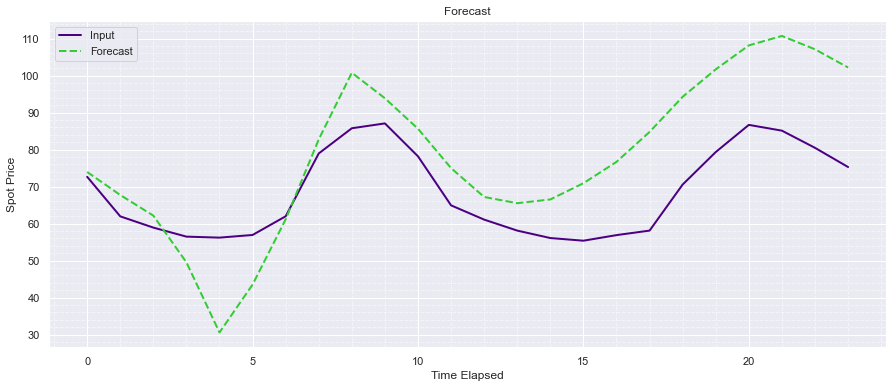

In [70]:
y = df_valid["Forecast_ARIMAX"].tolist()
#print(len(y))

#print(df[df.Date > "2015/12/31"].iloc[:,5])
#x = df[df.Date > "2015/12/31"].iloc[:,5]
x = list(range(0,len(y)))
#print(x)

plt.figure(figsize=(15,6))
plt.rcParams.update({"font.size" : 16})

plt.plot(x, df_valid["Spot price"], '-', color = 'indigo', label = 'Input', linewidth=2)
plt.plot(x, df_valid["Forecast_ARIMAX"],'--', color = 'limegreen', label = 'Forecast', linewidth=2)

#formatting
plt.grid(b=True, which='major', linestyle = 'solid')
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
plt.xlabel("Time Elapsed")
plt.ylabel("Spot Price")
plt.legend()
plt.title("Forecast")

In [71]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 16.493922458132992

MAE of Auto ARIMAX: 13.8678666874001
